## Imports

In [1]:
import os, sys

# if colab, mount drive and get the git repo
if 'google.colab' in sys.modules:
    from google.colab import drive
    print(os.getcwd())
    drive.mount('/content/drive')
    !git clone --recurse-submodules https://github.com/jsluijter02/LightSB_YOLO

    # Append LightSB_YOLO path
    sys.path.append(os.path.join(os.getcwd(), 'LightSB_YOLO'))

    ## TODO: 

# otherwise local path append
else:
    sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
np.random.seed(0)

# append the yolo model to path
from scripts.utils import dirs
dirs.add_YOLOPX_to_PATH()

from scripts.evals import boxes
from scripts.dataset.ultralytics_format import export_to_ultralytics_format
from scripts.dataset import bdd

from scripts.models.yolo import YOLOPX_BDD
from scripts.utils import img

/opt/anaconda3/envs/lightsb_yolo/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/lightsb_yolo/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Quantitative Analysis
### Precision, Recall, F1 per results folder

In [3]:
from scripts.evals import add_metrics

results_dir = os.path.join(dirs.get_base_dir(), 'results')

for experiment in sorted(os.listdir(results_dir)):
    if experiment == '6_compare' or experiment == 'logs':
        continue

    metrics = os.path.join(results_dir, experiment, 'predictions', 'metrics.json')
    exp_metrics = add_metrics.add_prec_recall_f1(metrics)

    print(experiment,": ", exp_metrics)

1_yolopx_real_night :  {'precision': 0.5073577716463014, 'recall': 0.83523495376629, 'f1': 0.631260600363733}
2.5_yolopx_rescaled :  {'precision': 0.49573578441304866, 'recall': 0.7275946903133363, 'f1': 0.5896930257017023}
2_yolopx_real_day :  {'precision': 0.5367112848456133, 'recall': 0.8750744370946196, 'f1': 0.665345056504953}
3_yolopx_AutoencoderKL_night :  {'precision': 0.3266080097087379, 'recall': 0.46640851363427116, 'f1': 0.38418557965761446}
4_yolopx_CLAHE_night_cliplimit_1 :  {'precision': 0.3306445357946172, 'recall': 0.46193855989597443, 'f1': 0.3854169021088082}
4_yolopx_CLAHE_night_cliplimit_2 :  {'precision': 0.3303912213740458, 'recall': 0.44989442910508365, 'f1': 0.3809916787016024}
4_yolopx_CLAHE_night_cliplimit_3 :  {'precision': 0.3334089315904499, 'recall': 0.4380841437975781, 'f1': 0.3786454369841363}
5_yolopx_lightsb_night :  {'precision': 0.2869303671755292, 'recall': 0.41163699522362135, 'f1': 0.33815251195505563}


## Qualitative Analysis

### TSNE between LightSB, Train day, Train night

In [4]:
from scripts.evals.TSNE import pca_tsne, plot_tsne

if not os.path.exists(os.path.join(dirs.get_base_dir(), 'results', '6_compare', 'TSNE', 'tsne_plot.png')):
    encodings_path = os.path.join(dirs.get_data_dir(), "encodings")
        
    train_day = np.load(os.path.join(encodings_path, "train_day.npz"))["latents"]
    train_night = np.load(os.path.join(encodings_path, "train_night.npz"))["latents"]
    light_sb_night_to_day = np.load(os.path.join(dirs.get_data_dir(), "encodings", "LightSB_transformed.npy"))
    print(len(light_sb_night_to_day))

    train_day_indices = img.sample_indices(len(train_day), how_many=3929)
    train_night_indices = img.sample_indices(len(train_night), how_many=3929)

    train_day = train_day[train_day_indices]
    train_night = train_night[train_night_indices]

    print(train_day.shape)
    print(train_night.shape)

    tsneres, labels = pca_tsne([train_day, train_night, light_sb_night_to_day])
    plot_tsne(tsneres, labels=labels, save_path=os.path.join(dirs.get_base_dir(), "tsne_plot.png"))

### GT vs AutoKL vs LightSB Sample Images

[ 582 3659 3924 3897  587]
['c3639d96-d284eda4.jpg', 'b5345bb2-a1424882.jpg', 'c0775b6f-d6afcd0e.jpg', 'ba181cb9-341963b1.jpg', 'b55569e8-282a99fe.jpg']


/opt/anaconda3/envs/lightsb_yolo/lib/python3.8/site-packages/albumentations/core/composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


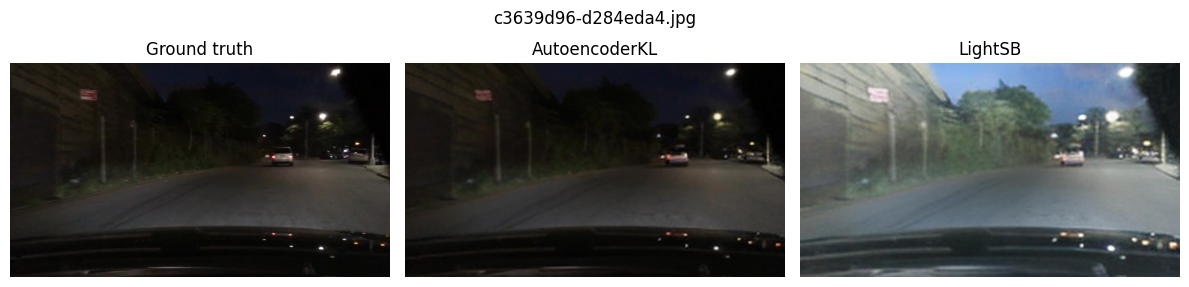

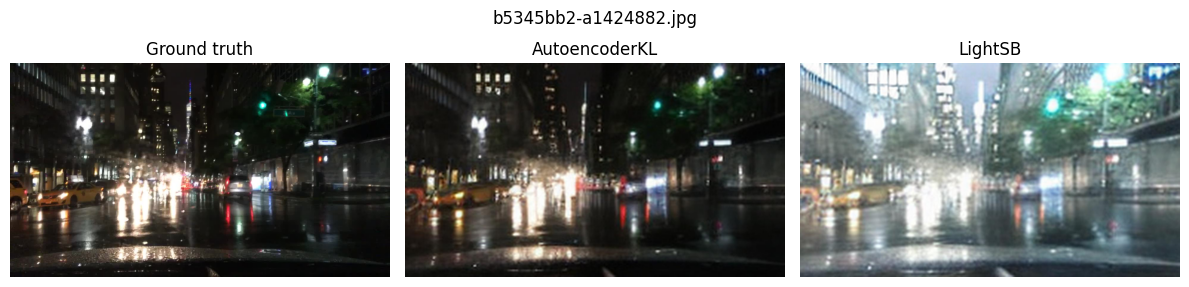

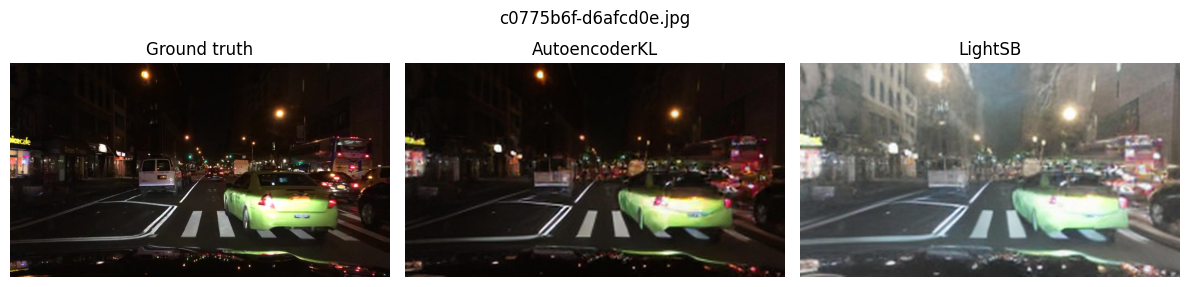

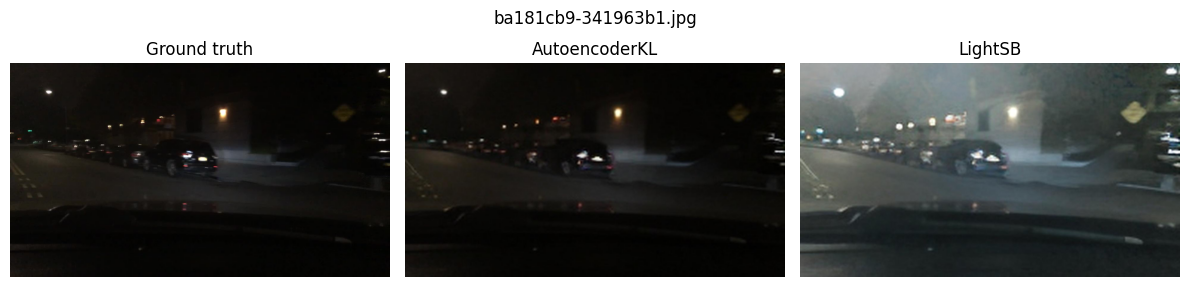

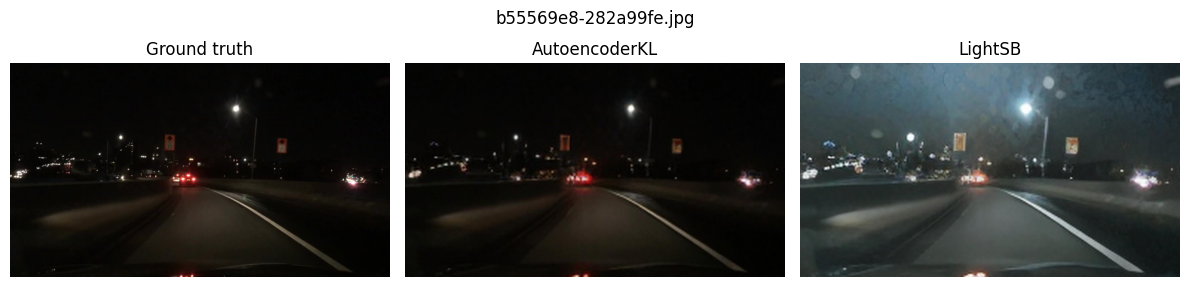

In [5]:
val_night_db = bdd.get_db(cfg=YOLOPX_BDD.standard_config(), is_train=False, timeofday='night')

images_path = os.path.join(dirs.get_data_dir(), 'images', 'val')
autokl_path = os.path.join(dirs.get_data_dir(), 'images_AutoencoderKL', 'val')
lightsb_path = os.path.join(dirs.get_data_dir(), 'images_LightSB', 'val')

samples = img.sample_indices(3929, 5)
filenames = [os.path.basename(val_night_db[i]['image']) for i in samples]

print(samples)
print(filenames)

save_dir = os.path.join(dirs.get_base_dir(), 'results', '6_compare', 'Qualitative_Analysis', 'Translation')
for name in filenames:
    gt = img.load_imgs(images_path, [name])[0]
    kl = img.load_imgs(autokl_path, [name])[0]
    sb = img.load_imgs(lightsb_path, [name])[0]

    img.plot_samples([gt,kl,sb], title=name, labels=["Ground truth", "AutoencoderKL", "LightSB"], square=False, save_dir=os.path.join(save_dir, name))

    


## Bounding Box Analysis: GT vs LightSB

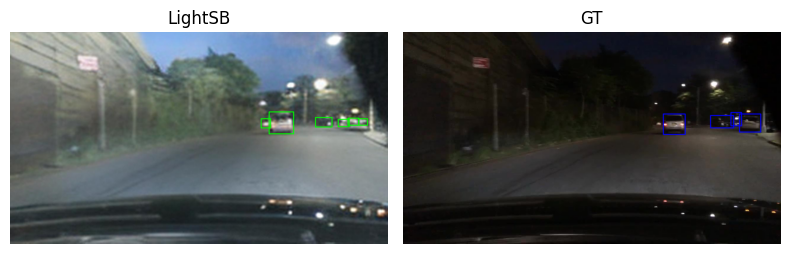

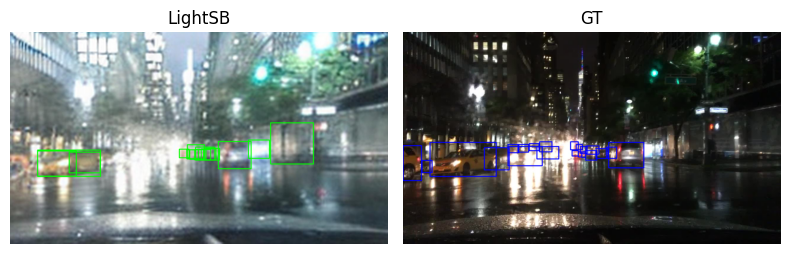

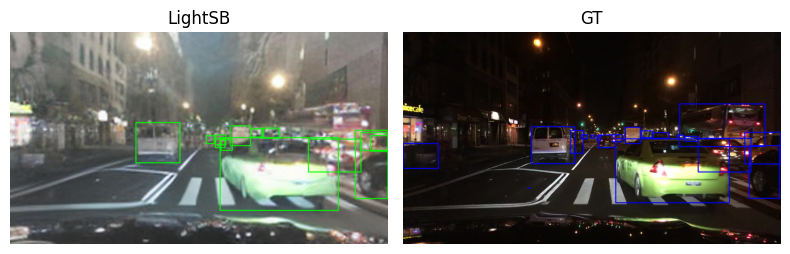

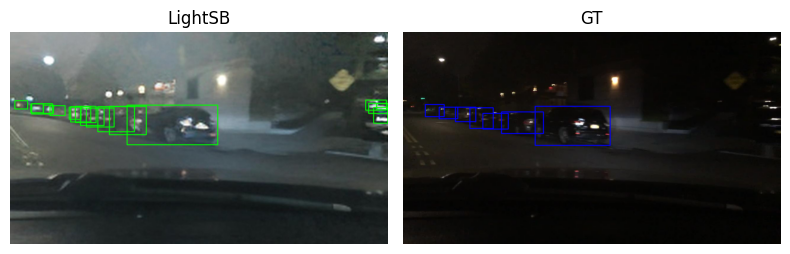

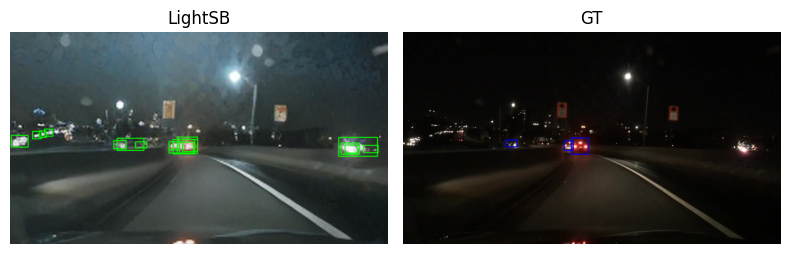

In [11]:
from scripts.evals import boxes
import cv2

save_dir = os.path.join(dirs.get_base_dir(), 'results', '6_compare', 'Qualitative_Analysis', 'Boxes')
os.makedirs(save_dir, exist_ok=True)

for name in filenames:
    sb = os.path.join(lightsb_path, name)
    label = os.path.join(dirs.get_base_dir(), 'results', '5_yolopx_lightsb_night', 'predictions', 'labels', boxes.jpg_to_txt(name))
    sb_boxes, gt_boxes = boxes.plot_prediction_gt_boxes(sb, label, split='val', conf_threshold=0.25)
    
    save_name = os.path.join(save_dir, name)
    img.plot_samples([cv2.cvtColor(sb_boxes, cv2.COLOR_BGR2RGB), cv2.cvtColor(gt_boxes, cv2.COLOR_BGR2RGB)], labels=["LightSB", "GT"], square=False, save_dir=save_name)

## LightSB Fail Cases

Check difference between F1-scores Baseline predictors and LightSB predictions. 
Bigger difference means LightSB made it worse.

In [7]:
baseline_json = os.path.join(dirs.get_base_dir(), 'results', '2_yolopx_real_day', 'predictions', 'metrics.json')
lightsb_json = os.path.join(dirs.get_base_dir(), 'results', '5_yolopx_lightsb_night', 'predictions', 'metrics.json')
add_metrics.compare_metrics(baseline_json, lightsb_json)

dict_values([{'tp': 19, 'fp': 26, 'fn': 0, 'precision': 0.4222222222222222, 'recall': 1.0, 'f1': 0.59375, 'num_gt': 19}, {'tp': 17, 'fp': 9, 'fn': 1, 'precision': 0.6538461538461539, 'recall': 0.9444444444444444, 'f1': 0.7727272727272727, 'num_gt': 18}, {'tp': 16, 'fp': 4, 'fn': 0, 'precision': 0.8, 'recall': 1.0, 'f1': 0.8888888888888888, 'num_gt': 16}, {'tp': 6, 'fp': 1, 'fn': 0, 'precision': 0.8571428571428571, 'recall': 1.0, 'f1': 0.9230769230769231, 'num_gt': 6}, {'tp': 14, 'fp': 2, 'fn': 0, 'precision': 0.875, 'recall': 1.0, 'f1': 0.9333333333333333, 'num_gt': 14}, {'tp': 11, 'fp': 37, 'fn': 3, 'precision': 0.22916666666666666, 'recall': 0.7857142857142857, 'f1': 0.3548387096774194, 'num_gt': 14}, {'tp': 8, 'fp': 6, 'fn': 3, 'precision': 0.5714285714285714, 'recall': 0.7272727272727273, 'f1': 0.64, 'num_gt': 11}, {'tp': 13, 'fp': 14, 'fn': 4, 'precision': 0.48148148148148145, 'recall': 0.7647058823529411, 'f1': 0.5909090909090909, 'num_gt': 17}, {'tp': 9, 'fp': 8, 'fn': 1, 'preci